# Validation of kmeans clustering
Author: Tristan Miller

I'm loosely following the validation method from Ryan P Adams' lecture notes, provided by Max.  The idea is to create test data with similar statistics to the real data, but with none of the clustering behavior.  Then kmeans is performed on the test data, and a clustering statistic is computed for both the test data and real data.  The best choice of k is that which maximizes the difference in the clustering statistic.

From previous discussion, I thought the best way to generate test data would be to take real data, and shuffle the dimensions of each term vector.

### Initializing

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
import scipy

In [34]:
data = pd.read_pickle("processed_10k_articles.pkl")
unweighted_words = numpy.reshape(numpy.load("document_term_matrix.npy"),(1))[0]
term_list = pd.read_pickle("term_list.pkl")[0].tolist()

In [3]:
#TF-IDF weighting can be applied after the fact with TfidfTransformer
Tfidf = TfidfTransformer()
#IDF weights only need to be calculated once, and can be reused for test data.
Tfidf.fit(unweighted_words)
#Now we apply the weights
real_data = Tfidf.transform(unweighted_words)

### Running kmeans

In [4]:
from sklearn.cluster import KMeans

In [217]:
#run kmeans on real data
kmeans=KMeans(n_clusters=12)
kmeans_pred=kmeans.fit_predict(real_data)
cluster_means = kmeans.cluster_centers_

In [218]:
#print out some information about a cluster
def cluster_info(cluster_index,cluster_means,kmeans_pred):
    #print out the top terms at the cluster center
    cluster_mean = pd.DataFrame(index=range(real_data.shape[1]),columns=['term','frequency'])
    cluster_mean['term']=term_list
    cluster_mean['frequency']=cluster_means[cluster_index]
    cluster_mean.sort_values('frequency',ascending=False,inplace=True)
    print(cluster_mean[0:10])

    #print out some titles
    print([data['title'][i] for i in range(len(data)) if kmeans_pred[i] == cluster_index][0:21])

cluster_info(0,cluster_means,kmeans_pred)

         term  frequency
222   municip   0.607114
95   district   0.220994
271   provinc   0.148308
97       east   0.119807
193      live   0.096183
373    websit   0.095420
231     north   0.093500
251     peopl   0.090607
279     refer   0.065433
238    offici   0.043709
['Heilongjiang', 'Utrecht (province)', 'Las Terrenas, Samaná', 'Obwalden', 'Leuk (district)', 'Visp (district)', 'Diessenhofen', 'Amlikon-Bissegg', 'Mendrisio (district)', 'Morbio Inferiore', 'Vacallo', 'Homburg, Switzerland', 'Salenstein', 'Baden, Switzerland', 'Benzenschwil', 'Adelboden', 'Zeiningen', 'Buchs, Aargau', 'Sabaneta, Santiago Rodríguez', 'Kerns', 'Wiliberg']


In [219]:
from scipy.spatial.distance import sqeuclidean

#Now let's get the clustering statistic
def cluster_statistic(bag_of_words,cluster_means,kmeans_pred):
    running_sum = [0]*len(cluster_means)
    
    for i in range(len(kmeans_pred)):
        #for each data point, add the square distance to the cluster center to the running sum
        running_sum[kmeans_pred[i]] += sqeuclidean(cluster_means[kmeans_pred[i]],bag_of_words[i,:].toarray())
    #normalize each cluster to the size of the cluster
    for k in range(len(running_sum)):
        cluster_size = len([i for i in range(len(kmeans_pred)) if kmeans_pred[i] == k])
        running_sum[k] /= cluster_size
    return sum(running_sum)

In [220]:
stat = cluster_statistic(real_data,cluster_means,kmeans_pred)
print(stat)

8.46563716262


### Generate test data

In [114]:
type(unweighted_words)

scipy.sparse.csr.csr_matrix

In [208]:
import random
def generate_test_data(unweighted_words):
    #Shuffles each column in a document-term matrix
    num_rows = unweighted_words.shape[0]
    num_cols = unweighted_words.shape[1]
    test_data = scipy.sparse.csc_matrix(unweighted_words)
    #in the csc_matrix format, "indices" is a complete list of rows for each nonzero element
    #and "indptr" tells you where in "indices" each new column starts
    
    #loop through each column
    for i in range(num_cols):
        #find the first and last indices of the data corresponding to the given column
        column_first = test_data.indptr[i] 
        column_last = test_data.indptr[i+1]
        #for each nonzero element in the column, assign it a new row at random.
        test_data.indices[column_first:column_last] = random.sample(range(num_rows),column_last-column_first)
    
    #convert back to csr
    test_data = scipy.sparse.csr_matrix(test_data)
    return test_data

In [202]:
#testing
arr = scipy.sparse.csr_matrix([[0,1,2],[0,0,3],[0,0,0]])
arr2 = generate_test_data(arr)
print(arr.toarray())
print(arr2.toarray())

[[0 1 2]
 [0 0 3]
 [0 0 0]]
[[0 0 3]
 [0 0 0]
 [0 1 2]]


In [205]:
random.randint(0,10000)

3372

In [207]:
#Finally, generate the test data
random.seed(3372)
test_matrix1 = generate_test_data(unweighted_words)
test_matrix2 = generate_test_data(test_matrix1)
#apply TF-IDF weighting to test data
test_data1 = Tfidf.transform(test_matrix1)
test_data2 = Tfidf.transform(test_matrix2)

In [221]:
kmeans_test1=kmeans.fit_predict(test_data1)
cm_test1 = kmeans.cluster_centers_
stat = cluster_statistic(test_data1,cm_test1,kmeans_test1)
print(stat)
#I expect this to be higher than it was for real data

9.18655121185


### Find optimal number of clusters

In [223]:
import time

In [250]:
stat_real = []
stat_test1 = []
stat_test2 = []
pred_real = []
means_real = []
pred_test1 = []
means_test1 = []
pred_test2 = []
means_test2 = []

start_time = time.time()
print("Applying kmeans clustering for k up to 20...")
for i in range(1,21):
    kmeans=KMeans(n_clusters=i)
    pred_real.append(kmeans.fit_predict(real_data))
    means_real.append(kmeans.cluster_centers_)
    stat_real.append(cluster_statistic(real_data,means_real[i-1],pred_real[i-1]))
    
    pred_test1.append(kmeans.fit_predict(test_data1))
    means_test1.append(kmeans.cluster_centers_)
    stat_test1.append(cluster_statistic(test_data1,means_test1[i-1],pred_test1[i-1]))
    
    pred_test2.append(kmeans.fit_predict(test_data2))
    means_test2.append(kmeans.cluster_centers_)
    stat_test2.append(cluster_statistic(test_data2,means_test2[i-1],pred_test2[i-1]))
    
    processing_time = (time.time() - start_time)/60
    print("Time: %.2f minutes. Progress: k = %d" % (processing_time,i) )

Applying kmeans clustering for k up to 20...
Time: 0.08 minutes. Progress: k = 1
Time: 0.47 minutes. Progress: k = 2
Time: 0.82 minutes. Progress: k = 3
Time: 1.18 minutes. Progress: k = 4
Time: 1.59 minutes. Progress: k = 5
Time: 2.05 minutes. Progress: k = 6
Time: 2.46 minutes. Progress: k = 7
Time: 2.92 minutes. Progress: k = 8
Time: 3.38 minutes. Progress: k = 9
Time: 3.90 minutes. Progress: k = 10
Time: 4.52 minutes. Progress: k = 11
Time: 5.20 minutes. Progress: k = 12
Time: 5.75 minutes. Progress: k = 13
Time: 6.28 minutes. Progress: k = 14
Time: 6.97 minutes. Progress: k = 15
Time: 7.61 minutes. Progress: k = 16
Time: 8.27 minutes. Progress: k = 17
Time: 8.99 minutes. Progress: k = 18
Time: 9.66 minutes. Progress: k = 19
Time: 10.23 minutes. Progress: k = 20


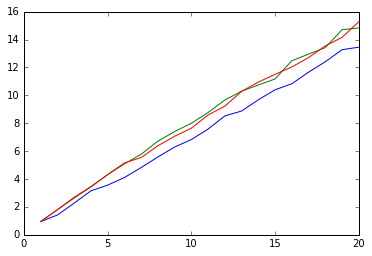

In [262]:
%matplotlib inline
plt.plot(range(1,21),stat_real,'',range(1,21),stat_test1,'',range(1,21),stat_test2,'')

<Container object of 3 artists>

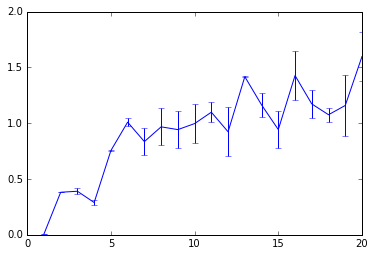

In [252]:
stat_diff = [(t1+t2)/2-r for (r,t1,t2) in zip(stat_real,stat_test1,stat_test2)]
stat_error = [abs(t1-t2)/2 for (r,t1,t2) in zip(stat_real,stat_test1,stat_test2)]
plt.errorbar(range(1,21),stat_diff,yerr = stat_error)

This result does not seem particularly helpful

### Trying other statistics

In [254]:
#Try a few variations on the clustering statistic
#This one divides by the number of clusters
def cluster_statistic2(bag_of_words,cluster_means,kmeans_pred):
    running_sum = [0]*len(cluster_means)
    
    for i in range(len(kmeans_pred)):
        #for each data point, add the square distance to the cluster center to the running sum
        running_sum[kmeans_pred[i]] += sqeuclidean(cluster_means[kmeans_pred[i]],bag_of_words[i,:].toarray())
    #normalize each cluster to the size of the cluster
    for k in range(len(running_sum)):
        cluster_size = len([i for i in range(len(kmeans_pred)) if kmeans_pred[i] == k])
        running_sum[k] /= cluster_size
    return numpy.mean(running_sum)

from scipy.spatial.distance import euclidean

#this one finds the average difference in distance between the two closest cluster means
#note that this won't work for a single cluster
def cluster_statistic3(bag_of_words,cluster_means,kmeans_pred):
    running_sum = 0
    
    for i in range(len(kmeans_pred)):
        #for each data point, find the distances to all clusters
        distances = []
        for j in range(len(cluster_means)):
            distances.append( euclidean(cluster_means[j],bag_of_words[i,:].toarray()) )
        distances.sort()
        running_sum += distances[1] - distances[0]
    running_sum /= len(kmeans_pred)
    
    return running_sum


In [255]:
stat2_real = []
stat2_test1 = []
stat2_test2 = []
for i in range(1,21):
    stat2_real.append(cluster_statistic2(real_data,means_real[i-1],pred_real[i-1]))
    stat2_test1.append(cluster_statistic2(test_data1,means_test1[i-1],pred_test1[i-1]))
    stat2_test2.append(cluster_statistic2(test_data2,means_test2[i-1],pred_test2[i-1]))

takes about a minute

In [256]:
stat3_real = []
stat3_test1 = []
stat3_test2 = []
for i in range(2,21):
    stat3_real.append(cluster_statistic3(real_data,means_real[i-1],pred_real[i-1]))
    stat3_test1.append(cluster_statistic3(test_data1,means_test1[i-1],pred_test1[i-1]))
    stat3_test2.append(cluster_statistic3(test_data2,means_test2[i-1],pred_test2[i-1]))

took about 15 minutes

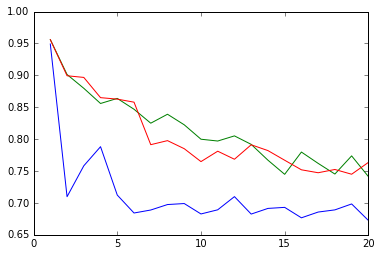

In [263]:
plt.plot(range(1,21),stat2_real,'',range(1,21),stat2_test1,'',range(1,21),stat2_test2,'')

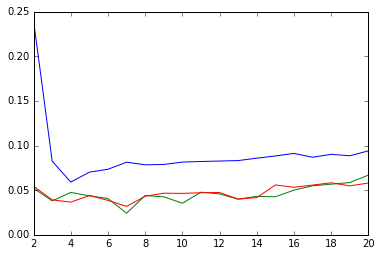

In [264]:
plt.plot(range(2,21),stat3_real,'',range(2,21),stat3_test1,'',range(2,21),stat3_test2,'')

<Container object of 3 artists>

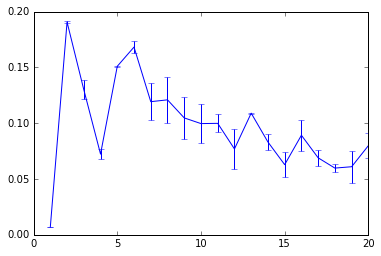

In [260]:
stat2_diff = [(t1+t2)/2-r for (r,t1,t2) in zip(stat2_real,stat2_test1,stat2_test2)]
stat2_error = [abs(t1-t2)/2 for (r,t1,t2) in zip(stat2_real,stat2_test1,stat2_test2)]
plt.errorbar(range(1,21),stat2_diff,yerr = stat2_error)

<Container object of 3 artists>

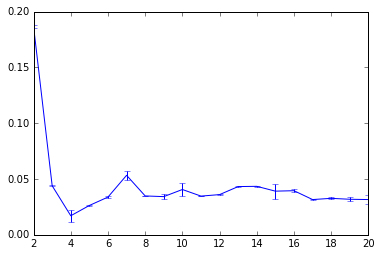

In [265]:
stat3_diff = [r-(t1+t2)/2 for (r,t1,t2) in zip(stat3_real,stat3_test1,stat3_test2)]
stat3_error = [abs(t1-t2)/2 for (r,t1,t2) in zip(stat3_real,stat3_test1,stat3_test2)]
plt.errorbar(range(2,21),stat3_diff,yerr = stat3_error)

Going by rms distance to cluster centers, 6 seems to be best.  To minimize clusters near boundaries, 7 seems to be best.

Okay, but how do I apply this to hierarchical agglomerative clustering?  Could be difficult...